#### **Import Library**

In [0]:
pip install PySastrawi

     |████████████████████████████████| 215kB 8.5MB/s 


In [0]:
pip install WordCloud

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
import time

from wordcloud import WordCloud
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('stopwords')
stop = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **Load Dataset**

In [0]:
df = pd.read_excel('fix_3030.xlsx', index_col=0)

In [0]:
df.shape

(3031, 5)

In [0]:
df.head()

,screen_name,username,text,label,target
0,pieterpitojo,pieterpitojo,Laporan pandangan mata langsung dari TKPhttps:...,1,0
1,pieterpitojo,pieterpitojo,Sayangnya ada sekelompok orang yang sedang dip...,-1,-1
2,pieterpitojo,pieterpitojo,Negara kita akan segera menjadi negara yang sa...,1,1
3,pieterpitojo,pieterpitojo,Kayaknya Dokdes @ryuhasan pernah bikin thread ...,1,0
4,pieterpitojo,pieterpitojo,Aku milih NASI MATERAIhttps://twitter.com/eko_...,1,0


**Relate Dataset**

In [0]:
pos_tweet = df['target'] == 1
neg_tweet = df['target'] == -1
neu_tweet = df['target'] == 0

new_df = (df[(pos_tweet) | (neg_tweet) | (neu_tweet)])

In [0]:
new_df = new_df[['text', 'target']]

In [0]:
new_df.shape

(2227, 2)

#### **Checking Nan Values**

In [0]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 3030
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2227 non-null   object
 1   target  2227 non-null   object
dtypes: object(2)
memory usage: 52.2+ KB


**Character and Word Visualization**

In [0]:
char_len = new_df['text'].str.len()
word_len = new_df['text'].str.split().map(lambda x: len(x))

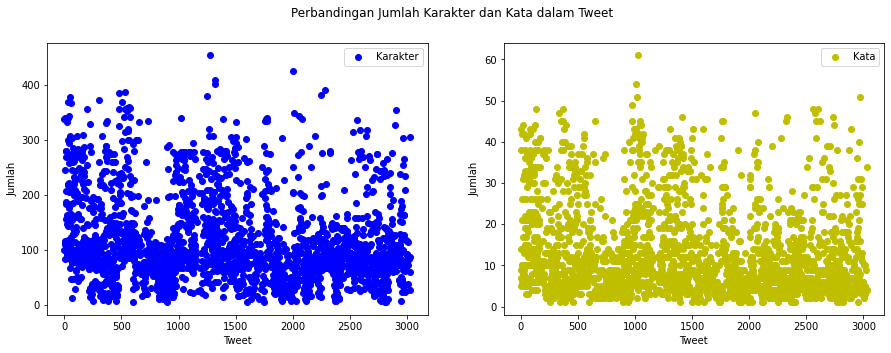

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Perbandingan Jumlah Karakter dan Kata dalam Tweet')

ax1.scatter(char_len.index, char_len.values, color='b', label='Karakter')
ax1.set_xlabel('Tweet')
ax1.set_ylabel('Jumlah')
ax1.legend()

ax2.scatter(word_len.index, word_len.values, color='y', label='Kata')
ax2.set_xlabel('Tweet')
ax2.set_ylabel('Jumlah')
ax2.legend()

plt.show()

## **Data Preprocessing**

**Remove Hashtag, Mention Tag, Numbering and Hyperlinks**

In [0]:
text_list = new_df['text'].tolist()

def remove_tag(text):
  text = re.sub(r'pic.twitter\S+', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'@\S+', '', text)
  text = re.sub(r'#\S+', '', text)
  text = re.sub('\d+', '', text)
  return text

tag_output = [remove_tag(sen) for sen in text_list]

new_df['without_tag'] = tag_output

**Spell Checker**

In [0]:
def spell_checker(text):
  pattern = re.compile(r'(.)\1{2,}')
  text = pattern.sub(r'\1\1', text)
  return text

spell_check = [spell_checker(sen) for sen in tag_output]

new_df['reduce_lenghtening'] = spell_check

**Remove Punctuation**

In [0]:
punct = list(string.punctuation)

def remove_punc(text):
  for punctuation in punct:
    text = text.replace(punctuation, ' ')
  return text

punct_output = [remove_punc(sen) for sen in spell_check]

new_df['without_punc'] = punct_output

In [0]:
new_df.head()

,text,target,without_tag,without_punc
0,Laporan pandangan mata langsung dari TKPhttps:...,0,Laporan pandangan mata langsung dari TKP …,Laporan pandangan mata langsung dari TKP …
1,Sayangnya ada sekelompok orang yang sedang dip...,-1,Sayangnya ada sekelompok orang yang sedang dip...,Sayangnya ada sekelompok orang yang sedang dip...
2,Negara kita akan segera menjadi negara yang sa...,1,Negara kita akan segera menjadi negara yang sa...,Negara kita akan segera menjadi negara yang sa...
3,Kayaknya Dokdes @ryuhasan pernah bikin thread ...,0,"Kayaknya Dokdes pernah bikin thread ini, ya? …",Kayaknya Dokdes pernah bikin thread ini ya …
4,Aku milih NASI MATERAIhttps://twitter.com/eko_...,0,Aku milih NASI MATERAI …,Aku milih NASI MATERAI …


**Lowercase Process**

In [0]:
def to_lowercase(text):
  return text.lower() 

lower_text = [to_lowercase(sen) for sen in punct_output]

new_df['to_lowercase'] = lower_text

In [0]:
new_df.head()

,text,target,without_tag,without_punc,to_lowercase
0,Laporan pandangan mata langsung dari TKPhttps:...,0,Laporan pandangan mata langsung dari TKP …,Laporan pandangan mata langsung dari TKP …,laporan pandangan mata langsung dari tkp …
1,Sayangnya ada sekelompok orang yang sedang dip...,-1,Sayangnya ada sekelompok orang yang sedang dip...,Sayangnya ada sekelompok orang yang sedang dip...,sayangnya ada sekelompok orang yang sedang dip...
2,Negara kita akan segera menjadi negara yang sa...,1,Negara kita akan segera menjadi negara yang sa...,Negara kita akan segera menjadi negara yang sa...,negara kita akan segera menjadi negara yang sa...
3,Kayaknya Dokdes @ryuhasan pernah bikin thread ...,0,"Kayaknya Dokdes pernah bikin thread ini, ya? …",Kayaknya Dokdes pernah bikin thread ini ya …,kayaknya dokdes pernah bikin thread ini ya …
4,Aku milih NASI MATERAIhttps://twitter.com/eko_...,0,Aku milih NASI MATERAI …,Aku milih NASI MATERAI …,aku milih nasi materai …


**Stemming Process**

In [0]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_preprocessing(sens):
  return stemmer.stem(sens)

stem_output = [stemming_preprocessing(sen) for sen in lower_text]

new_df['stemming'] = stem_output

In [0]:
new_df.head()

,text,target,without_tag,without_punc,to_lowercase,stemming
0,Laporan pandangan mata langsung dari TKPhttps:...,0,Laporan pandangan mata langsung dari TKP …,Laporan pandangan mata langsung dari TKP …,laporan pandangan mata langsung dari tkp …,lapor pandang mata langsung dari tkp
1,Sayangnya ada sekelompok orang yang sedang dip...,-1,Sayangnya ada sekelompok orang yang sedang dip...,Sayangnya ada sekelompok orang yang sedang dip...,sayangnya ada sekelompok orang yang sedang dip...,sayang ada kelompok orang yang sedang pakai ge...
2,Negara kita akan segera menjadi negara yang sa...,1,Negara kita akan segera menjadi negara yang sa...,Negara kita akan segera menjadi negara yang sa...,negara kita akan segera menjadi negara yang sa...,negara kita akan segera jadi negara yang sanga...
3,Kayaknya Dokdes @ryuhasan pernah bikin thread ...,0,"Kayaknya Dokdes pernah bikin thread ini, ya? …",Kayaknya Dokdes pernah bikin thread ini ya …,kayaknya dokdes pernah bikin thread ini ya …,kayak dokdes pernah bikin thread ini ya
4,Aku milih NASI MATERAIhttps://twitter.com/eko_...,0,Aku milih NASI MATERAI …,Aku milih NASI MATERAI …,aku milih nasi materai …,aku milih nasi materai


**Tokenize**

In [0]:
token = new_df['stemming'].str.split()
token_list = token.values.tolist()

new_df['tokenize'] = token_list

In [0]:
new_df.head()

,text,target,without_tag,without_punc,to_lowercase,stemming,tokenize
0,Laporan pandangan mata langsung dari TKPhttps:...,0,Laporan pandangan mata langsung dari TKP …,Laporan pandangan mata langsung dari TKP …,laporan pandangan mata langsung dari tkp …,lapor pandang mata langsung dari tkp,"[lapor, pandang, mata, langsung, dari, tkp]"
1,Sayangnya ada sekelompok orang yang sedang dip...,-1,Sayangnya ada sekelompok orang yang sedang dip...,Sayangnya ada sekelompok orang yang sedang dip...,sayangnya ada sekelompok orang yang sedang dip...,sayang ada kelompok orang yang sedang pakai ge...,"[sayang, ada, kelompok, orang, yang, sedang, p..."
2,Negara kita akan segera menjadi negara yang sa...,1,Negara kita akan segera menjadi negara yang sa...,Negara kita akan segera menjadi negara yang sa...,negara kita akan segera menjadi negara yang sa...,negara kita akan segera jadi negara yang sanga...,"[negara, kita, akan, segera, jadi, negara, yan..."
3,Kayaknya Dokdes @ryuhasan pernah bikin thread ...,0,"Kayaknya Dokdes pernah bikin thread ini, ya? …",Kayaknya Dokdes pernah bikin thread ini ya …,kayaknya dokdes pernah bikin thread ini ya …,kayak dokdes pernah bikin thread ini ya,"[kayak, dokdes, pernah, bikin, thread, ini, ya]"
4,Aku milih NASI MATERAIhttps://twitter.com/eko_...,0,Aku milih NASI MATERAI …,Aku milih NASI MATERAI …,aku milih nasi materai …,aku milih nasi materai,"[aku, milih, nasi, materai]"


In [0]:
from nltk.probability import FreqDist

result = []
for sublist in token_list:
    for item in sublist:
        result.append(item)

print(result)

['lapor', 'pandang', 'mata', 'langsung', 'dari', 'tkp', 'sayang', 'ada', 'kelompok', 'orang', 'yang', 'sedang', 'pakai', 'gerak', 'untuk', 'hancur', 'kerja', 'nyata', 'ini', 'mereka', 'guna', 'isu', 'china', 'yang', 'memang', 'sensitif', 'sejak', 'lama', 'untuk', 'acau', 'jalan', 'jadi', 'bangsa', 'besar', 'ini', 'orang', 'orang', 'ini', 'adalah', 'cundang', 'sampah', 'politik', 'milu', 'negara', 'kita', 'akan', 'segera', 'jadi', 'negara', 'yang', 'sangat', 'hitung', 'beberapa', 'tahun', 'ke', 'depan', 'apa', 'yang', 'dulu', 'cuma', 'utopia', 'saat', 'ini', 'akan', 'segera', 'wujud', 'nyata', 'nikel', 'lithium', 'battery', 'kering', 'untuk', 'mobil', 'listrik', 'sel', 'surya', 'stainless', 'steel', 'semua', 'bakal', 'kita', 'punya', 'pabrik', 'wow', 'kayak', 'dokdes', 'pernah', 'bikin', 'thread', 'ini', 'ya', 'aku', 'milih', 'nasi', 'materai', 'mohon', 'bantu', 'sekira', 'ada', 'yang', 'kenal', 'bapak', 'ini', 'cari', 'anak', 'yg', 'ada', 'di', 'jakarta', 'eco', 'tidak', 'ada', 'yang',

In [0]:
kemunculan = nltk.FreqDist(result)
print(kemunculan.most_common())

[('yang', 456), ('di', 368), ('ini', 351), ('dan', 286), ('yg', 264), ('ada', 239), ('itu', 219), ('orang', 174), ('ya', 147), ('apa', 145), ('jadi', 142), ('untuk', 136), ('dari', 134), ('bisa', 134), ('kita', 132), ('sama', 132), ('aku', 124), ('aja', 122), ('lagi', 118), ('tidak', 112), ('dengan', 110), ('tapi', 107), ('mau', 107), ('ga', 106), ('buat', 101), ('udah', 100), ('hari', 99), ('masih', 91), ('ke', 90), ('nya', 89), ('juga', 89), ('akan', 86), ('gak', 85), ('kalo', 84), ('saya', 82), ('indonesia', 81), ('lebih', 80), ('mereka', 77), ('adalah', 76), ('punya', 73), ('atau', 73), ('pada', 72), ('baik', 71), ('corona', 71), ('kerja', 70), ('sudah', 69), ('pak', 68), ('semua', 67), ('jangan', 67), ('banget', 67), ('banyak', 66), ('makan', 65), ('bagi', 63), ('bukan', 63), ('rumah', 63), ('satu', 62), ('negara', 61), ('harus', 61), ('saat', 60), ('karena', 59), ('covid', 58), ('salah', 58), ('mana', 57), ('sih', 57), ('tak', 56), ('dalam', 56), ('dia', 55), ('selamat', 55), ('g

In [0]:
type(kemunculan)

nltk.probability.FreqDist

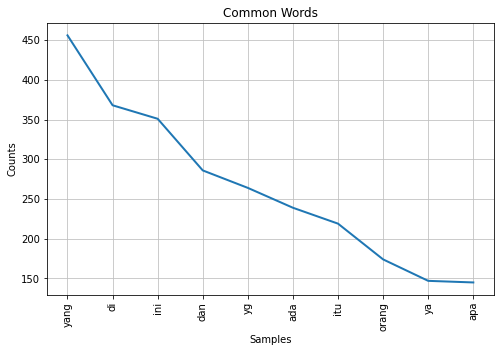

In [0]:
fig, ax = plt.subplots(figsize=(8,5))

kemunculan.plot(10,cumulative=False, title='Common Words')

plt.show()

**Remove Stopwords**

In [0]:
stoplist = stopwords.words('indonesian')

stoplist.remove('tidak')

def remove_stopwords(tokens):
  return [word for word in tokens if word not in stoplist]

stopwords_output = [remove_stopwords(sen) for sen in token_list]

new_df['without_stopwords'] = stopwords_output

In [0]:
new_df.tail()

,text,target,without_tag,without_punc,to_lowercase,stemming,tokenize,without_stopwords
3015,Tidak punya hati nurani.https://twitter.com/ja...,-1,Tidak punya hati nurani. …,Tidak punya hati nurani …,tidak punya hati nurani …,tidak punya hati nurani,"[tidak, punya, hati, nurani]","[tidak, hati, nurani]"
3026,Tipu Daya China Kepada Rombongan Indonesia di ...,-1,Tipu Daya China Kepada Rombongan Indonesia di ...,Tipu Daya China Kepada Rombongan Indonesia di ...,tipu daya china kepada rombongan indonesia di ...,tipu daya china kepada rombong indonesia di ka...,"[tipu, daya, china, kepada, rombong, indonesia...","[tipu, daya, china, rombong, indonesia, kamp, ..."
3028,Pemerintah Hadirkan B30 Pertamahttps://youtu.b...,0,Pemerintah Hadirkan B Pertama,Pemerintah Hadirkan B Pertama,pemerintah hadirkan b pertama,perintah hadir b pertama,"[perintah, hadir, b, pertama]","[perintah, hadir, b]"
3029,Hidup sekali jangan gagal.,1,Hidup sekali jangan gagal.,Hidup sekali jangan gagal,hidup sekali jangan gagal,hidup sekali jangan gagal,"[hidup, sekali, jangan, gagal]","[hidup, gagal]"
3030,Logisnya yang begini dilakukan oleh kepala des...,0,Logisnya yang begini dilakukan oleh kepala des...,Logisnya yang begini dilakukan oleh kepala des...,logisnya yang begini dilakukan oleh kepala des...,logis yang begini laku oleh kepala desa kepala...,"[logis, yang, begini, laku, oleh, kepala, desa...","[logis, laku, kepala, desa, kepala, negara, pi..."


In [0]:
from nltk.probability import FreqDist

r_stopwords = []
for sublist in stopwords_output:
    for item in sublist:
        r_stopwords.append(item)

print(r_stopwords)

['lapor', 'pandang', 'mata', 'langsung', 'tkp', 'sayang', 'kelompok', 'orang', 'pakai', 'gerak', 'hancur', 'kerja', 'nyata', 'isu', 'china', 'sensitif', 'acau', 'jalan', 'bangsa', 'orang', 'orang', 'cundang', 'sampah', 'politik', 'milu', 'negara', 'negara', 'hitung', 'utopia', 'wujud', 'nyata', 'nikel', 'lithium', 'battery', 'kering', 'mobil', 'listrik', 'sel', 'surya', 'stainless', 'steel', 'pabrik', 'wow', 'kayak', 'dokdes', 'bikin', 'thread', 'ya', 'milih', 'nasi', 'materai', 'mohon', 'bantu', 'sekira', 'kenal', 'cari', 'anak', 'yg', 'jakarta', 'eco', 'tidak', 'makhluk', 'cc', 'tanggap', 'sisi', 'psikologi', 'anak', 'marah', 'emosi', 'kayak', 'gin', 'kenan', 'tidak', 'ganggu', 'etika', 'profesi', 'matur', 'nuwun', 'kl', 'bener', 'knp', 'tdk', 'jabat', 'oknums', 'bro', 'berani', 'bangun', 'pagi', 'jalan', 'hidup', 'krn', 'harap', 'alas', 'vaksin', 'covid', 'masyarakat', 'yg', 'tular', 'turun', 'trendnya', 'harap', 'muncul', 'mohon', 'terap', 'putus', 'terapi', 'plasma', 'korban', 'co

In [0]:
k_stopwords = nltk.FreqDist(r_stopwords)
print(k_stopwords.most_common())

[('yg', 264), ('orang', 174), ('ya', 147), ('aja', 122), ('tidak', 112), ('ga', 106), ('udah', 100), ('nya', 89), ('gak', 85), ('kalo', 84), ('indonesia', 81), ('corona', 71), ('kerja', 70), ('banget', 67), ('makan', 65), ('rumah', 63), ('negara', 61), ('covid', 58), ('salah', 58), ('sih', 57), ('selamat', 55), ('gw', 55), ('moga', 52), ('pagi', 51), ('nih', 51), ('agama', 50), ('bikin', 49), ('hidup', 48), ('gin', 45), ('hati', 44), ('virus', 43), ('laku', 41), ('anak', 40), ('manusia', 40), ('jalan', 39), ('ken', 39), ('tp', 39), ('pas', 38), ('rakyat', 38), ('tau', 38), ('ngga', 37), ('perintah', 37), ('liat', 37), ('tuhan', 36), ('kaya', 36), ('gue', 36), ('presiden', 35), ('masuk', 35), ('buka', 35), ('emang', 35), ('allah', 34), ('nyata', 33), ('kali', 33), ('suka', 33), ('pake', 32), ('cinta', 32), ('kuat', 32), ('jam', 32), ('kayak', 31), ('puasa', 31), ('lihat', 31), ('sehat', 31), ('sampe', 31), ('main', 30), ('langsung', 29), ('pulang', 29), ('kasih', 29), ('butuh', 29), ('b

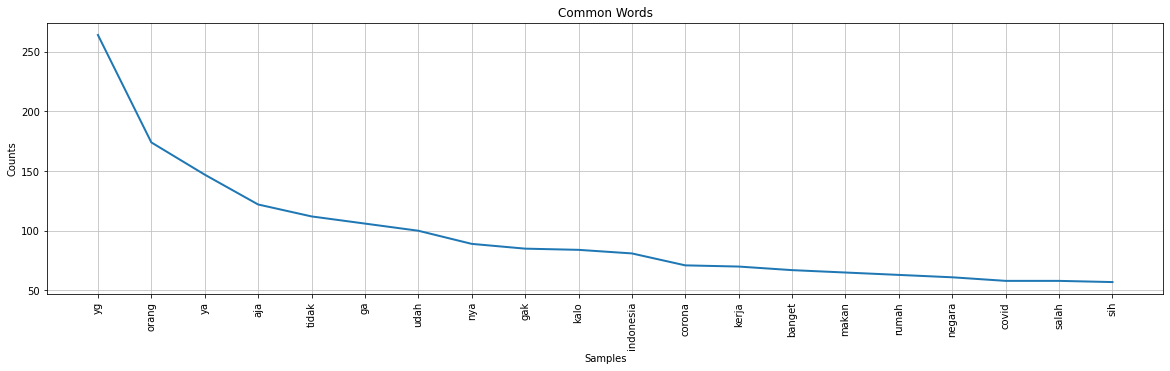

In [0]:
fig, ax = plt.subplots(figsize=(20,5))

k_stopwords.plot(20,cumulative=False, title='Common Words')

plt.show()

## **Result Cleaning Process**

In [0]:
result = [' '.join(sen) for sen in stopwords_output]

new_df['clean_text'] = result
new_df = new_df[['text', 'clean_text', 'target']]

### **Export to Excel File**

In [0]:
# from google.colab import files

# new_df.to_excel('clean_dataset.xlsx') 
# files.download('clean_dataset.xlsx')

In [0]:
from google.colab import files

new_df.to_excel('fix_3030_tweets_eda.xlsx') 
files.download('fix_3030_tweets_eda.xlsx')

### **WordCloud Visualization**

**Show Negative Word Cloud**

In [0]:
neg_tweets = new_df[new_df.target == 0]
neg_string = []

for word in neg_tweets.clean_text:
  neg_string.append(word)

neg_string = pd.Series(neg_string).str.cat(sep=' ')

**Show Positive Word Cloud**

In [0]:
pos_tweets = new_df[new_df.target == 1]
pos_string = []

for word in pos_tweets.clean_text:
  pos_string.append(word)

pos_string = pd.Series(pos_string).str.cat(sep=' ')

**Visualization WordCloud**

In [0]:
wordcloud1 = WordCloud(width = 1600,
                      height = 800,
                      background_color='white',
                      max_font_size = 200).generate(neg_string)

wordcloud2 = WordCloud(width = 1600,
                      height = 800,
                      background_color='white',
                      max_font_size = 200).generate(pos_string)

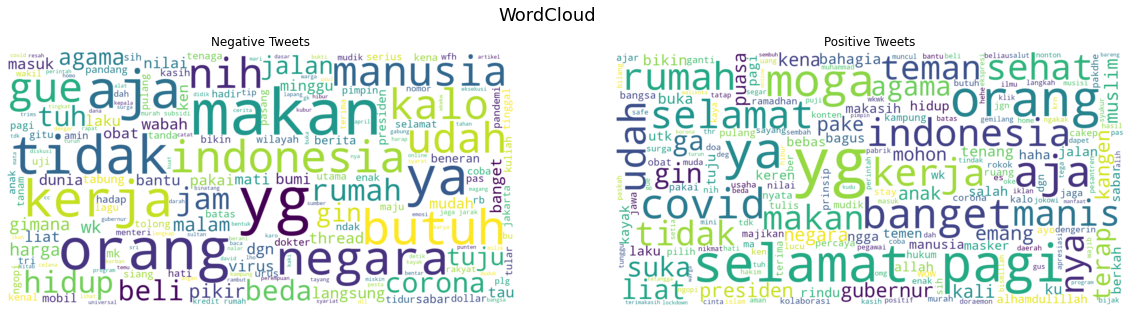

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('WordCloud', fontsize=18)

ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Negative Tweets')

ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Positive Tweets')

plt.show()